Device with name Apple M1 supports metal minimum requirements
Finsihed opening molecule after 0.14909499999999998 seconds
Adding object to scene.
Added res_id after 7.799999999980045e-05 s
Added res_name after 0.0006019999999997694 s
Added atomic_number after 0.0007369999999999877 s
Added b_factor after 2.5999999999637424e-05 s
Added vdw_radii after 0.0007500000000000284 s
Added chain_id after 0.00017300000000020077 s
Added entity_id after 7.600000000040907e-05 s
Added atom_name after 0.00046400000000001995 s
Added lipophobicity after 0.0008010000000000517 s
Added charge after 0.0008330000000000837 s
Added is_backbone after 0.0001349999999997742 s
Added is_alpha_carbon after 3.5999999999702936e-05 s
Added is_solvent after 3.7000000000286803e-05 s
Added is_nucleic after 0.000296000000000074 s
Added is_peptide after 0.0004460000000001685 s
Added is_hetero after 2.4999999999941735e-05 s
Added is_carb after 0.00028100000000019776 s
Added sec_struct after 0.00041599999999997195 s
Finsihed a

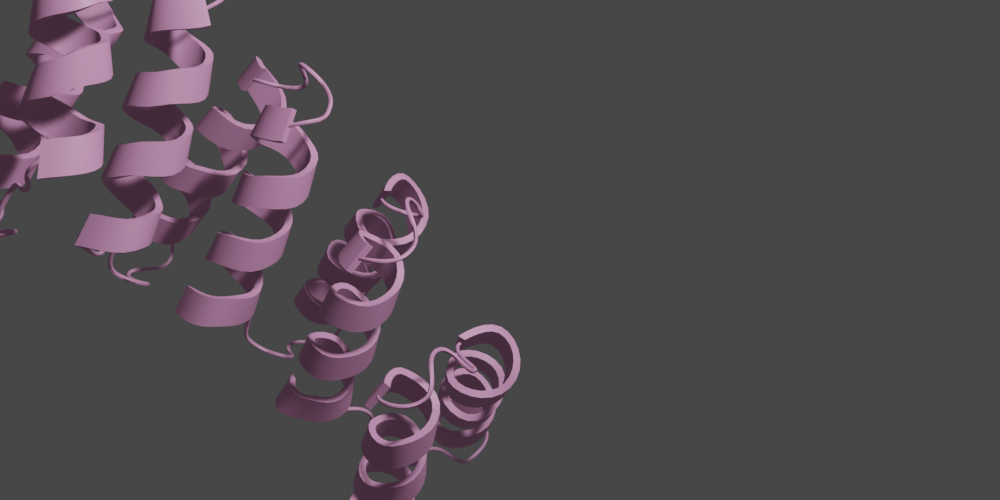

In [1]:
import molecularnodes as mn
from IPython.display import Image
import bpy

# Delete all mesh objects from the scene
bpy.ops.object.select_all(action="DESELECT")
bpy.ops.object.select_by_type(type="MESH")
bpy.ops.object.delete()

molecule = mn.load.molecule_rcsb("4OZS", starting_style="cartoon", center_molecule=True)
molecule.location.z += 1.3
molecule.scale = [6, 6, 6]

# Camera
camera = bpy.data.objects["Camera"]
camera.location = (5, -3, 4)
camera.data.dof.use_dof = True
camera.data.dof.focus_distance = 5
camera.data.dof.aperture_fstop = 4

# Render
path = "test.png"
bpy.context.scene.render.resolution_x = 1000
bpy.context.scene.render.resolution_y = 500
bpy.context.scene.render.image_settings.file_format = "PNG"
bpy.context.scene.render.filepath = path
bpy.ops.render.render(write_still=True)
bpy.data.images["Render Result"].save_render(filepath=bpy.context.scene.render.filepath)

Image("test.png")